In [8]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from PIL import Image
import timm
from torchvision import transforms
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [9]:
# --- 2. CONFIGURATION ---
DATA_ROOT = '/kaggle/input/leukemia/Original' 
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']
SAMPLES_PER_CLASS = 10  # "Choose 10 samples from each"
BATCH_SIZE = 16         # Small batch for small data
EPOCHS = 15             # Quick training per fold
LR = 1e-4
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")

Device: cuda


In [10]:
# --- 3. DATA PREPARATION (SELECTING ONLY 40 IMAGES) ---
print(f"--- Selecting Random {SAMPLES_PER_CLASS} Images per Class ---")
selected_paths = []
selected_labels = []

class_to_idx = {cls_name: i for i, cls_name in enumerate(CLASSES)}

for cls_name in CLASSES:
    cls_folder = os.path.join(DATA_ROOT, cls_name)
    all_files = glob.glob(os.path.join(cls_folder, '*'))
    
    # Randomly pick exactly 10
    if len(all_files) >= SAMPLES_PER_CLASS:
        chosen_files = random.sample(all_files, SAMPLES_PER_CLASS)
    else:
        # Safety fallback if a folder has <10 images
        print(f"Warning: {cls_name} only has {len(all_files)} images!")
        chosen_files = all_files
        
    for f in chosen_files:
        selected_paths.append(f)
        selected_labels.append(class_to_idx[cls_name])

print(f"Total Dataset Size: {len(selected_paths)} images")

--- Selecting Random 10 Images per Class ---
Total Dataset Size: 40 images


In [11]:
# --- 4. RAM-CACHED DATASET ---
class CachedDataset(Dataset):
    def __init__(self, file_paths, labels, img_size):
        self.data = []
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        print(f"Caching tiny dataset to RAM...")
        for img_path in tqdm(file_paths, desc="Loading"):
            with Image.open(img_path) as img:
                self.data.append(transforms.Resize((img_size, img_size))(img.convert('RGB')))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.transform(self.data[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

dataset = CachedDataset(selected_paths, selected_labels, IMG_SIZE)

Caching tiny dataset to RAM...


Loading:   0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
# --- 1. UPDATED TRAINING FUNCTION (PRINTS EACH RESULT) ---
def train_loo_iteration(train_idx, test_idx, run_id, total_runs):
    # Setup Loaders
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    # Test loader has only 1 image
    test_loader = DataLoader(Subset(dataset, test_idx), batch_size=1, shuffle=False, num_workers=0)
    
    # Model Setup
    model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=4).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    
    # Train Loop (Quick)
    for epoch in range(EPOCHS):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
    # Test on the ONE left-out image
    model.eval()
    prediction = -1
    actual = -1
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            prediction = predicted.item()
            actual = targets.item()
            
    return prediction, actual

In [15]:
# --- 2. LEAVE-ONE-OUT EXECUTION ---
loo = LeaveOneOut()
all_preds = []
all_targets = []
total_runs = len(dataset)

print(f"\nStarting LOO Cross-Validation on {total_runs} samples...\n")
print(f"{'Run ID':<10} | {'Actual (Left-Out)':<20} | {'Predicted':<20} | {'Result'}")
print("-" * 65)

for i, (train_idx, test_idx) in enumerate(loo.split(dataset)):
    pred, target = train_loo_iteration(train_idx, test_idx, i, total_runs)
    
    all_preds.append(pred)
    all_targets.append(target)
    
    # --- PRINT RESULT FOR EACH SAMPLE ---
    actual_name = CLASSES[target]
    pred_name = CLASSES[pred]
    status = "✅ Correct" if pred == target else "❌ WRONG"
    
    print(f"Run {i+1:<6} | {actual_name:<20} | {pred_name:<20} | {status}")


Starting LOO Cross-Validation on 40 samples...

Run ID     | Actual (Left-Out)    | Predicted            | Result
-----------------------------------------------------------------
Run 1      | Benign               | Early                | ❌ WRONG
Run 2      | Benign               | Pro                  | ❌ WRONG
Run 3      | Benign               | Benign               | ✅ Correct
Run 4      | Benign               | Pre                  | ❌ WRONG
Run 5      | Benign               | Early                | ❌ WRONG
Run 6      | Benign               | Pre                  | ❌ WRONG
Run 7      | Benign               | Pre                  | ❌ WRONG
Run 8      | Benign               | Early                | ❌ WRONG
Run 9      | Benign               | Early                | ❌ WRONG
Run 10     | Benign               | Early                | ❌ WRONG
Run 11     | Early                | Early                | ✅ Correct
Run 12     | Early                | Benign               | ❌ WRONG
Run 13     


==================== FINAL SUMMARY ====================
Overall Accuracy: 52.50% (21/40 Correct)


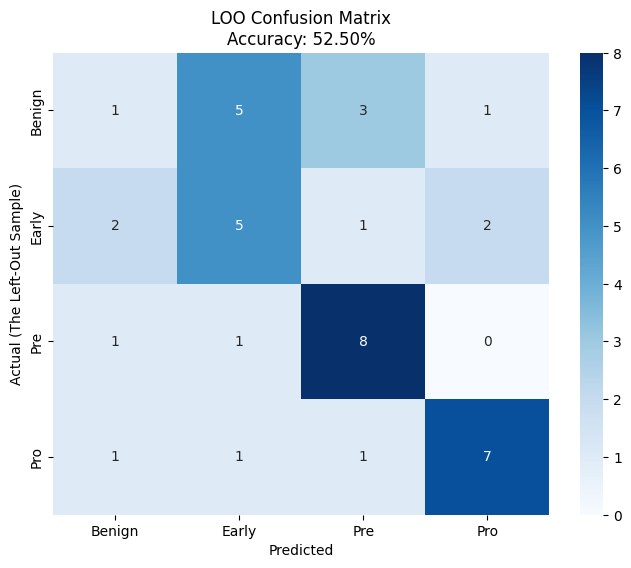

In [16]:
# --- 3. FINAL RESULTS ---
print(f"\n{'='*20} FINAL SUMMARY {'='*20}")
correct_count = sum([1 for i in range(len(all_preds)) if all_preds[i] == all_targets[i]])
accuracy = 100 * correct_count / total_runs
print(f"Overall Accuracy: {accuracy:.2f}% ({correct_count}/{total_runs} Correct)")

# Plot Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual (The Left-Out Sample)')
plt.title(f'LOO Confusion Matrix\nAccuracy: {accuracy:.2f}%')
plt.show()